In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Activation, Dropout, BatchNormalization, Conv2DTranspose, Concatenate 
from tensorflow.keras.optimizers import Adam

# U-net construction

In [2]:
def conv_block(input_layer, n_base, batchnorm = False):
    output_layer = Conv2D(filters= n_base, kernel_size=(3,3), strides=(1,1), padding='same')(input_layer)
    if batchnorm :
        output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('relu')(output_layer)
    output_layer = Conv2D(filters=n_base, kernel_size=(3,3), strides=(1,1), padding='same')(output_layer)
    if batchnorm :
        output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('relu')(output_layer)
    return output_layer

In [3]:
def encoder_block(input_layer,n_base , batchnorm = False, dropout = False):
    out = conv_block(input_layer, n_base, batchnorm = batchnorm)
    out2 = MaxPooling2D(pool_size=(2,2))(out)
    if dropout:
        out2 = Dropout(0.2)(out2)
    return out, out2

In [4]:
def decoder_block(input_layer, layer2conc, n_base, batchnorm = False, dropout = False):
    output_layer = Conv2DTranspose(filters = n_base,  kernel_size=(3,3), strides=(2, 2), padding="same")(input_layer)
    output_layer = Concatenate()([output_layer, layer2conc])
    if dropout:
        output_layer = Dropout(0.2)(output_layer)
    output_layer = conv_block(output_layer, n_base, batchnorm = batchnorm)
    return output_layer

In [5]:
def get_unet(img_ch, img_width, img_height, n_base, dropout = False, batchnormal = False, binary = True, class_num = 2):
    input_layer = Input(shape=(img_width, img_height, img_ch))
    
    #Encoder
    e1, em1 = encoder_block(input_layer, n_base, batchnorm = batchnormal, dropout = dropout)
    e2, em2 = encoder_block(em1, n_base*2, batchnorm = batchnormal, dropout = dropout)
    e3, em3 = encoder_block(em2, n_base*4, batchnorm = batchnormal, dropout = dropout)
    e4, em4 = encoder_block(em3, n_base*8, batchnorm = batchnormal, dropout = dropout)

    #Bottleneck 
    bottleneck = conv_block(em4, n_base*16, batchnorm = batchnormal)

    #Decoder
    d_block1 = decoder_block(bottleneck, e4, n_base*8, batchnorm = batchnormal, dropout = dropout)
    d_block2 = decoder_block(d_block1, e3, n_base*4, batchnorm = batchnormal, dropout = dropout)
    d_block3 = decoder_block(d_block2, e2, n_base*2, batchnorm = batchnormal, dropout = dropout)
    d_block4 = decoder_block(d_block3, e1, n_base, batchnorm = batchnormal, dropout = dropout)
    
    #Output
    if binary:
        out = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'sigmoid')(d_block4)
    else:
        out = Conv2D(filters=class_num, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'sigmoid')(d_block4)
        
    clf = Model(inputs=input_layer, outputs=out)
    clf.summary()
    
    return clf    

In [6]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Data loading

In [7]:
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

In [8]:
def get_mask(data_path, mask_labels, img_h, img_w, split_ratio):
    """
    Parameters
    ----------
    data_path : Str
        Path to the data directory
    mask_labels : List
        A list containing the name of the mask files.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.    
    split_ratio : Float
        Ratio between 0 and 1 giving the proportion of train data over the all dataset
    Returns
    -------
    train_mask_list : List
        A list containing the train mask images along with their
        corresponding labels.
    trest_mask_list : List
        A list containing the test mask images along with their
        corresponding labels.
    """
    mask_list = []
    for label in mask_labels:
        mask = imread(data_path + 'Mask/' + label, as_gray = True) # "as_grey"
        mask = resize(mask, (img_h, img_w), anti_aliasing = True).astype('float32')
        mask_list.append([(np.array(mask)-np.min(np.array(mask)))/(np.max(np.array(mask))-np.min(np.array(mask))), label])
    shuffle(mask_list)
    train_mask_list = mask_list[:int(split_ratio*len(mask_list))]
    test_mask_list = mask_list[int(split_ratio*len(mask_list)):]
    return train_mask_list, test_mask_list


def get_data(data_path, mask_labels, img_h, img_w, split_ratio = 0.8):
    #Loading the shuffled and splitted lists of mask images with their corresponding labels
    train_mask_list, test_mask_list = get_mask(data_path, mask_labels, img_h, img_w, split_ratio)
    
    #Initialising the train arrays
    train_img = np.zeros((len(train_mask_list), img_h, img_w), dtype = np.float32)
    train_mask = np.zeros((len(train_mask_list), img_h, img_w), dtype = np.float32)
    for ind in range(len(train_mask_list)):
        #Adding the mask in the ytrain array
        train_mask[ind] = train_mask_list[ind][0]
        #Adding the corresponding image in the xtrain array
        label = train_mask_list[ind][1]
        img = imread(data_path + 'Image/' + label, as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_img[ind] = (np.array(img)-np.min(np.array(img)))/(np.max(np.array(img))-np.min(np.array(img)))
        #Print the advancement
        if ind%10==0:
            a = ind/len(train_mask_list)
            print('Train dataset : ', str(int(100*a)), '%')
        elif ind+1 == len(train_mask_list):
            print('Train dataset : 100%')
    train_img = np.expand_dims(train_img, axis =3)
    train_mask = np.expand_dims(train_mask, axis =3)
    
    #Initialising the test arrays
    test_img = np.zeros((len(test_mask_list), img_h, img_w), dtype = np.float32)
    test_mask = np.zeros((len(test_mask_list), img_h, img_w), dtype = np.float32)
    for ind in range(len(test_mask_list)):
        #Adding the mask in the ytest array
        test_mask[ind] = test_mask_list[ind][0]
        #Adding the corresponding image in the xtest array
        label = test_mask_list[ind][1]
        img = imread(data_path + 'Image/' + label, as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_img[ind] = (np.array(img)-np.min(np.array(img)))/(np.max(np.array(img))-np.min(np.array(img)))
        #Print the advancement
        if ind%10==0:
            a = ind/len(test_mask_list)
            print('Test dataset : ', str(int(100*a)), '%')
        elif ind+1 == len(test_mask_list):
            print('Test dataset : 100%')
    test_img = np.expand_dims(test_img, axis =3)
    test_mask = np.expand_dims(test_mask, axis =3)
        
    return train_img, train_mask, test_img, test_mask

In [9]:
img_w, img_h = 256, 256 
data_path = '/DL_course_data/Lab3/X_ray/'
mask_labels = os.listdir(data_path + 'Mask/')
x_train, y_train, x_test, y_test = get_data(data_path, mask_labels, img_h, img_w, split_ratio = 0.8)

Train dataset :  0 %
Train dataset :  5 %
Train dataset :  10 %
Train dataset :  16 %
Train dataset :  21 %
Train dataset :  26 %
Train dataset :  32 %
Train dataset :  37 %
Train dataset :  42 %
Train dataset :  48 %
Train dataset :  53 %
Train dataset :  58 %
Train dataset :  64 %
Train dataset :  69 %
Train dataset :  74 %
Train dataset :  80 %
Train dataset :  85 %
Train dataset :  90 %
Train dataset :  96 %
Train dataset : 100%
Test dataset :  0 %
Test dataset :  21 %
Test dataset :  42 %
Test dataset :  63 %
Test dataset :  85 %
Test dataset : 100%


In [ ]:
#Verify the normalization

for image in range(x_test.shape[0]):
    if np.min(x_test[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(x_test[image, :, :, 0]))
    if np.max(x_test[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(x_test[image, :, :, 0]))
    if np.min(y_test[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(y_test[image, :, :, 0]))
    if np.max(y_test[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(y_test[image, :, :, 0]))
print('Test checked')
  
for image in range(x_train.shape[0]):
    if np.min(x_train[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(x_train[image, :, :, 0]))
    if np.max(x_train[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(x_train[image, :, :, 0]))
    if np.min(y_train[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(y_train[image, :, :, 0]))
    if np.max(y_train[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(y_train[image, :, :, 0]))
print('Train checked')    

# Task 1A

In [ ]:
img_ch, img_w, img_h = 1, 256, 256
n_base = 8
n_epochs = 150
batchsize = 8
LR = 0.0001

clf = get_unet(img_ch, img_w, img_h, n_base)
clf.compile(loss='binary_crossentropy', optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data=(x_test, y_test))

In [ ]:
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1A/loss_curves.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1A/accuracy_curves.png', dpi = 200)

# Task 1B

In [ ]:
img_ch, img_w, img_h = 1, 256, 256
n_base = 8
n_epochs = 150
batchsize = 8
LR = 0.0001

clf = get_unet(img_ch, img_w, img_h, n_base)
clf.compile(loss=[dice_coef_loss], optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data=(x_test, y_test))

In [ ]:
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1B/loss_curves.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1B/accuracy_curves.png', dpi = 200)

# Task 1C

In [ ]:
img_ch, img_w, img_h = 1, 256, 256
n_base = 8
n_epochs = 150
batchsize = 8
LR = 0.0001

clf = get_unet(img_ch, img_w, img_h, n_base, dropout = True)
clf.compile(loss='binary_crossentropy', optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data=(x_test, y_test))
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1C/loss_BCE.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1C/accuracy_BCE.png', dpi = 200)




clf = get_unet(img_ch, img_w, img_h, n_base, dropout = True)
clf.compile(loss=[dice_coef_loss], optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data=(x_test, y_test))
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1C/loss_DCL.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1C/accuracy_DCL.png', dpi = 200)

# Task 1D

In [ ]:
img_ch, img_w, img_h = 1, 256, 256
n_base = 32
n_epochs = 150
batchsize = 8
LR = 0.0001

clf = get_unet(img_ch, img_w, img_h, n_base, dropout = True)
clf.compile(loss='binary_crossentropy', optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data=(x_test, y_test))
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1D/loss_BCE.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1D/accuracy_BCE.png', dpi = 200)




clf = get_unet(img_ch, img_w, img_h, n_base, dropout = True)
clf.compile(loss=[dice_coef_loss], optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data=(x_test, y_test))
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1D/loss_DCL.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1D/accuracy_DCL.png', dpi = 200)

# Task 1E

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [13]:
img_ch, img_w, img_h = 1, 256, 256
n_base = 16
n_epochs = 150
batchsize = 8
LR = 0.0001


#Train dataset
image_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)

mask_datagen = ImageDataGenerator(rotation_range = 10,
                                  width_shift_range = 0.1,
                                  height_shift_range=0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)

# image_datagen.fit(x_train, augment=True, seed = 0)
# mask_datagen.fit(y_train, augment=True, seed = 0)
x_train_flow = image_datagen.flow(x_train, batch_size=batchsize, seed = 0)
y_train_flow = mask_datagen.flow(y_train, batch_size=batchsize, seed = 0)


#Test dataset
image_val_datagen = ImageDataGenerator()
mask_val_datagen = ImageDataGenerator()

# image_val_datagen.fit(x_train, augment=True, seed = 0)
# mask_val_datagen.fit(y_train, augment=True, seed = 0)
x_test_flow = image_val_datagen.flow(x_test, batch_size=batchsize, seed = 0)
y_test_flow = mask_val_datagen.flow(y_test, batch_size=batchsize, seed = 0)



train_generator = (pair for pair in zip(x_train_flow, y_train_flow))
val_generator = (pair for pair in zip(x_test_flow, y_test_flow))

In [ ]:
clf = get_unet(img_ch, img_w, img_h, n_base, dropout = True, batchnormal = True)
clf.compile(loss='binary_crossentropy', optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit_generator(train_generator, epochs = n_epochs, validation_data=val_generator, steps_per_epoch=5, validation_steps=10)

#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1E/loss_BCE.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1E/accuracy_BCE.png', dpi = 200)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

5/5 [==============================] - 16s 3s/step - loss: 0.6412 - dice_coef: 0.3588 - val_loss: 0.6257 - val_dice_coef: 0.3743
Epoch 2/150
5/5 [==============================] - 1s 126ms/step - loss: 0.5530 - dice_coef: 0.4470 - val_loss: 0.6248 - val_dice_coef: 0.3752
Epoch 3/150
5/5 [==============================] - 1s 128ms/step - loss: 0.4802 - dice_coef: 0.5198 - val_loss: 0.6174 - val_dice_coef: 0.3826
Epoch 4/150
5/5 [==============================] - 1s 126ms/step - loss: 0.4750 - dice_coef: 0.5250 - val_loss: 0.6166 - val_dice_coef: 0.3834
Epoch 5/150
5/5 [==============================] - 1s 198ms/step - loss: 0.4474 - dice_coef: 0.5548 - val_loss: 0.6102 - val_dice_coef: 0.3898
Epoch 6/150
5/5 [==============================] - 1s 131ms/step - loss: 0.4529 - dice_coef: 0.5471 - val_loss: 0.6107 - val_dice_coef: 0.3893
Epoch 7/150
5/5 [==============================] - 1s 129ms/step - loss: 0.4112 - dice_coef: 0.5888 - val_loss: 0.6060 - val_dice_coef: 0.3940
Epoch 8/150
5

5/5 [==============================] - 1s 122ms/step - loss: 0.1533 - dice_coef: 0.8483 - val_loss: 0.8270 - val_dice_coef: 0.1730
Epoch 59/150
5/5 [==============================] - 1s 131ms/step - loss: 0.2011 - dice_coef: 0.7989 - val_loss: 0.8318 - val_dice_coef: 0.1682
Epoch 60/150
5/5 [==============================] - 1s 130ms/step - loss: 0.1918 - dice_coef: 0.8082 - val_loss: 0.8242 - val_dice_coef: 0.1758
Epoch 61/150
5/5 [==============================] - 1s 128ms/step - loss: 0.2277 - dice_coef: 0.7723 - val_loss: 0.8433 - val_dice_coef: 0.1567
Epoch 62/150
5/5 [==============================] - 1s 129ms/step - loss: 0.1948 - dice_coef: 0.8052 - val_loss: 0.8598 - val_dice_coef: 0.1402
Epoch 63/150
5/5 [==============================] - 1s 124ms/step - loss: 0.2170 - dice_coef: 0.7777 - val_loss: 0.8645 - val_dice_coef: 0.1355
Epoch 64/150
5/5 [==============================] - 1s 128ms/step - loss: 0.2107 - dice_coef: 0.7893 - val_loss: 0.8767 - val_dice_coef: 0.1233
Epoch

Epoch 115/150
5/5 [==============================] - 1s 130ms/step - loss: 0.0908 - dice_coef: 0.9092 - val_loss: 0.1658 - val_dice_coef: 0.8342
Epoch 116/150
5/5 [==============================] - 1s 123ms/step - loss: 0.1380 - dice_coef: 0.8638 - val_loss: 0.0937 - val_dice_coef: 0.9063
Epoch 117/150
5/5 [==============================] - 1s 132ms/step - loss: 0.1381 - dice_coef: 0.8619 - val_loss: 0.0982 - val_dice_coef: 0.9018
Epoch 118/150
5/5 [==============================] - 1s 130ms/step - loss: 0.1578 - dice_coef: 0.8422 - val_loss: 0.1229 - val_dice_coef: 0.8771
Epoch 119/150
5/5 [==============================] - 1s 133ms/step - loss: 0.1120 - dice_coef: 0.8880 - val_loss: 0.1093 - val_dice_coef: 0.8907
Epoch 120/150
5/5 [==============================] - 1s 124ms/step - loss: 0.2151 - dice_coef: 0.7886 - val_loss: 0.0949 - val_dice_coef: 0.9051
Epoch 121/150
5/5 [==============================] - 1s 131ms/step - loss: 0.0898 - dice_coef: 0.9102 - val_loss: 0.1059 - val_dic

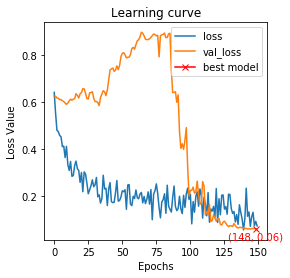

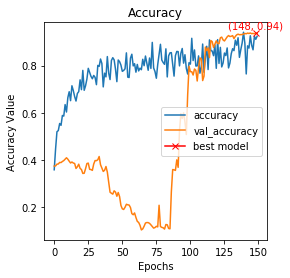

In [12]:
clf = get_unet(img_ch, img_w, img_h, n_base, dropout = True, batchnormal = True)
clf.compile(loss=[dice_coef_loss], optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit_generator(train_generator, epochs = n_epochs, validation_data=val_generator, steps_per_epoch=5, validation_steps=10)

#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.savefig('1E/loss_DCL.png', dpi = 200)

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();
plt.savefig('1E/accuracy_DCL.png', dpi = 200)